In [1]:
"""

Last change on Tue Aug 27 2024

Calculation of slant column density (molecules/cm²) of the simulated plume

with inputs from Dr. Alexandros Panagiotis Poulidis, University of Bremen

@author: lgrosch@iup.physik.uni-bremen.de

"""

'\n\nLast change on Tue Aug 27 2024\n\nCalculation of slant column density (molecules/cm²) of the simulated plume\n\nwith inputs from Dr. Alexandros Panagiotis Poulidis, University of Bremen\n\n@author: lgrosch@iup.physik.uni-bremen.de\n\n'

In [15]:
import numpy as np
import netCDF4 as nc
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [16]:
# Load the NetCDF file
file_path = 'C:/Users/admin/Desktop/Bremen/Semester_4_24/Masterarbeit/flexpart/grid_conc_20240514010000_CO2.nc'
dataset = nc.Dataset(file_path)

# Extract the dimensions needed
time = dataset.variables['time'][:]
longitude = dataset.variables['longitude'][:]
latitude = dataset.variables['latitude'][:]
heights = dataset.variables['height'][:]
spec001_mr = dataset.variables['spec001_mr'][:]

In [17]:
#current_time = start_time + timedelta(seconds=int(dataset.variables['time'][53]))
#current_time

In [18]:
# Load the solar zenith and azimuth angles from the EM27 CSV file
angles_df = pd.read_csv("C:/Users/admin/Desktop/Bremen/Semester_4_24/Masterarbeit/ratios/comb_invparms_Stahlwerk_hb_2_SN082_240514-240514.csv", sep="\t",)  # Assumes columns: 'UTC', 'appSZA', 'azimuth'

# Convert 'UTC' column to datetime format
angles_df['UTC'] = pd.to_datetime(angles_df['UTC'])

# Define the start time of the simulation
start_time = datetime(2024, 5, 14, 1, 0, 0)  # 2024-05-14 01:00:00

In [19]:
# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['UTC', 'emission (ng/cm^-2)', 'zenith', 'azimuth'])
#steps_df = pd.DataFrame(columns=['UTC', 'step emission (ng/cm^-2)', 'alt', 'lon', 'lat'])

In [20]:
lat0 = 53.145   # Station latitude
lon0 = 8.6597    # Station longitude
alt0 = 0        # Station altitude (ground level)

In [21]:
# Function that finds the indices of the grid that the given point lies within.

def find_grid_indices(lat, lon, alt, lat_grid, lon_grid, alt_grid):
    
    lat_idx = np.abs(lat_grid - lat).argmin()               # choose latitude grid point closest to given one
    lon_idx = np.abs(lon_grid - lon).argmin()               # choose longitude grid point closest to given one
    alt_idx = np.searchsorted(alt_grid, alt, side='right')  # choose next higher altitude level
    return lat_idx, lon_idx, alt_idx

In [22]:
# Iterate through each time index
for time_index in range(spec001_mr.shape[2]):
    
    # Calculate the current UTC time based on time_index
    current_time = start_time + timedelta(seconds=int(dataset.variables['time'][time_index]))
    
    # Find the closest UTC time in the solar angles data
    closest_time = angles_df.iloc[(angles_df['UTC'] - current_time).abs().argmin()]
    
    # Extract the corresponding solar angles
    solar_zenith_angle = closest_time['appSZA']
    solar_azimuth_angle = closest_time['azimuth']
    
    # Convert angles to radians
    zenith_rad = np.deg2rad(solar_zenith_angle)
    azimuth_rad = np.deg2rad(solar_azimuth_angle)
    
    # Calculate maximal model column latitude
    min_latitude = latitude.min()

    # Define vector components for that column
    lat_dy = abs(lat0 - min_latitude)
    meter_dy = lat_dy * 111111.0

    meter_dx = np.tan(azimuth_rad) * meter_dy
    lon_dx = meter_dx / (111111.0 * np.cos(np.deg2rad(lat0)))

    meter_dz = np.sqrt(meter_dx**2+meter_dy**2) * np.tan((np.pi/2)-zenith_rad)
    
    # Direction vector in meter for path length calculation
    degree_vector = np.array([lon_dx, lat_dy, meter_dz])
    meter_vector = np.array([meter_dx, meter_dy, meter_dz])
    column_length = np.sqrt(meter_dx**2+meter_dy**2+meter_dz**2)
    
    # Select the correct time slice and reduce dimensions
    spec001_mr_slice = spec001_mr[0, 0, time_index, :, :, :]  # Shape: (77, 30, 50)

    # Steps along the slant path
    total_steps = 2000 

    # Initialize
    path_length = 0
    total_concentration = 0
    path_concentration_sum = 0
    lat = lat0
    lon = lon0
    alt = alt0

    # Traverse the slant column
    while alt < 2000:
        lat_idx, lon_idx, alt_idx = find_grid_indices(lat, lon, alt, latitude, longitude, heights)

        # Calculate concentration at the current position
        conc = spec001_mr_slice[alt_idx, lat_idx, lon_idx]

        # Calculate the path length within this grid box (approximation)
        path_length = column_length / total_steps

        # Sum the path-concentration product (ng/m^2)
        path_concentration_sum += conc * path_length
        
        # Save intermediate steps
        #steps_df = steps_df.append({'UTC': current_time,
        #                              'step emission (ng/cm^-2)': conc,
        #                              'alt': alt_idx,
        #                              'lon':lon_idx,
        #                              'lat':lat_idx},
        #                             ignore_index=True)
        
        # Update the position
        lon -= degree_vector[0] / total_steps
        lat -= degree_vector[1] / total_steps
        alt += meter_vector[2] / total_steps

    # Convert the result from m^-2 to cm^-2
    total_column_concentration = path_concentration_sum / 10000

    # Store the result in the DataFrame
    results_df = results_df.append({'UTC': current_time,
                                    'emission (ng/cm^-2)': total_column_concentration,
                                    'zenith': solar_zenith_angle,
                                    'azimuth': solar_azimuth_angle}, 
                                   ignore_index=True)

# Save the results to a CSV file
#results_df.to_csv('C:/Users/admin/Desktop/Bremen/Semester_4_24/Masterarbeit/flexpart/slant_column_concentration_SW2.csv', sep=';', decimal=',', index=False)

#print("Results saved to column_concentration_results.csv")

C:\Users\admin\AppData\Local\Temp\ipykernel_27012\942321496.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'UTC': current_time,
C:\Users\admin\AppData\Local\Temp\ipykernel_27012\942321496.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'UTC': current_time,
C:\Users\admin\AppData\Local\Temp\ipykernel_27012\942321496.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'UTC': current_time,
C:\Users\admin\AppData\Local\Temp\ipykernel_27012\942321496.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'

C:\Users\admin\AppData\Local\Temp\ipykernel_27012\942321496.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'UTC': current_time,
C:\Users\admin\AppData\Local\Temp\ipykernel_27012\942321496.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'UTC': current_time,
C:\Users\admin\AppData\Local\Temp\ipykernel_27012\942321496.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'UTC': current_time,
C:\Users\admin\AppData\Local\Temp\ipykernel_27012\942321496.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'

C:\Users\admin\AppData\Local\Temp\ipykernel_27012\942321496.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'UTC': current_time,
C:\Users\admin\AppData\Local\Temp\ipykernel_27012\942321496.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'UTC': current_time,
C:\Users\admin\AppData\Local\Temp\ipykernel_27012\942321496.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'UTC': current_time,
C:\Users\admin\AppData\Local\Temp\ipykernel_27012\942321496.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'

C:\Users\admin\AppData\Local\Temp\ipykernel_27012\942321496.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'UTC': current_time,
C:\Users\admin\AppData\Local\Temp\ipykernel_27012\942321496.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'UTC': current_time,
C:\Users\admin\AppData\Local\Temp\ipykernel_27012\942321496.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'UTC': current_time,
C:\Users\admin\AppData\Local\Temp\ipykernel_27012\942321496.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'

In [ ]:
#print(steps_df.head(20))

In [23]:
print(f"The calculation stopped at (lat, lon, alt): {lat}, {lon}, {alt}")

The calculation stopped at (lat, lon, alt): 53.13347500030507, 8.644633519378624, 2000.2121729306102


In [31]:
short=results_df.iloc[66:73]
print(short)
#short.to_csv('C:/Users/admin/Desktop/Bremen/Semester_4_24/Masterarbeit/flexpart/slant_column_concentration_CO2_SW2.csv', sep=';', decimal=',', index=False)

                   UTC  emission (ng/cm^-2)  zenith  azimuth
66 2024-05-14 12:10:00         4.650247e+08   36.32    25.03
67 2024-05-14 12:20:00         4.147720e+08   36.32    25.03
68 2024-05-14 12:30:00         4.976501e+08   36.81    27.83
69 2024-05-14 12:40:00         4.074669e+08   37.51    31.36
70 2024-05-14 12:50:00         4.654022e+08   38.38    35.16
71 2024-05-14 13:00:00         6.126239e+08   39.13    38.10
72 2024-05-14 13:10:00         5.128352e+08   39.13    38.10


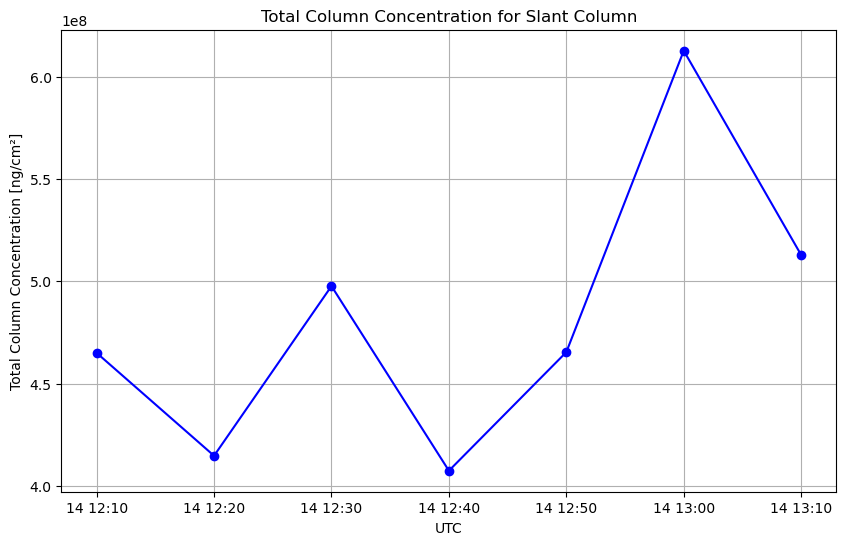

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(short['UTC'], short['emission (ng/cm^-2)'], marker='o', linestyle='-', color='b')
plt.xlabel('UTC')
plt.ylabel('Total Column Concentration [ng/cm²]')
plt.title('Total Column Concentration for Slant Column')
plt.grid(True)

# Save the plot to a file
#plt.savefig('C:/Users/admin/Desktop/Bremen/Semester_4_24/Masterarbeit/flexpart/slant_column_SW1.png', bbox_inches='tight', dpi=300)  # Adjust dpi for quality

plt.show()